# VAE

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


## import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

## import keras packages

In [10]:
from keras.models import Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.utils import np_utils
from keras import backend as K

## load dataset MNIST

In [48]:
from keras.datasets import mnist
(x_train0, _), _ = mnist.load_data()

x_train = x_train0.reshape(60000, -1)

x_train -= x_train.min()
# x_train /= x_train.max() # invalid for type of x_train being 'uint8'
x_train = x_train / x_train.max()

## construct VAE

### graph
Because 2-dimension latent layer is done in the class, I try 5-dimension one.
[<img src = "https://i.imgur.com/UXa4FVg.png" style="width:500px;">](https://hackmd.io/s/S1hBAL4TV)
<div style="text-align:right">(Click the image to see the source code.)</div>

In [17]:
enc = Dense(100, activation='sigmoid')

enc_mean = Dense(5)
enc_logvar = Dense(5)

dec = Dense(100, activation='sigmoid')

dec_output = Dense(784, activation='sigmoid')

#### define nomral sampling function

In [18]:
def normalSampling(argv):
    z_mean, zlogvar = argv
    eps = K.random_normal(shape=(5,), mean=0., stddev=1)
    return z_mean + K.exp(z_logvar / 2) * eps

In [19]:
x = Input(shape=(784,))

enc_x = enc(x)

z_mean = enc_mean(enc_x)
z_logvar = enc_logvar(enc_x)

z = Lambda(normalSampling, output_shape=(5,))([z_mean, z_logvar])

dec_z = dec(z)

x_hat = dec_output(dec_z)

In [20]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 5)            505         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 5)            505         dense_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

#### define VAE's loss function

In [24]:
def vae_loss(x, x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis = -1)
    return recovery_loss + kl_loss

In [50]:
VAE.compile(loss=vae_loss, optimizer=Adam(0.0009487))

In [51]:
VAE.fit(x_train, x_train, batch_size=30, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 20s 334us/step - loss: 136.6600
Epoch 2/10
60000/60000 [==============================] - 19s 318us/step - loss: 135.5373
Epoch 3/10
60000/60000 [==============================] - 18s 307us/step - loss: 134.4680
Epoch 4/10
60000/60000 [==============================] - 20s 337us/step - loss: 133.6237
Epoch 5/10
60000/60000 [==============================] - 19s 317us/step - loss: 132.9813
Epoch 6/10
60000/60000 [==============================] - 16s 275us/step - loss: 132.3249
Epoch 7/10
60000/60000 [==============================] - 17s 275us/step - loss: 131.8109
Epoch 8/10
60000/60000 [==============================] - 18s 300us/step - loss: 131.3745
Epoch 9/10
60000/60000 [==============================] - 20s 325us/step - loss: 130.8938
Epoch 10/10
60000/60000 [==============================] - 17s 284us/step - loss: 130.5483


## visualization

In [52]:
Encoder = Model(x, z_mean)

h = Input(shape=(5,))
Decoder = Model(h ,dec_output(dec(h)))

Because I have 5 dimension, I skip something that cannot show in 2 dimension. (比較想玩滑桿)

In [75]:
def inBetween(t, s):
    data_100 = x_train0[idx_100]
    data_010 = x_train0[idx_010]
    data_001 = x_train0[idx_001]
    data_ts = (1 - t - s)*data_100 + t*data_010 + s*data_001
    
    mu_100 = Encoder.predict(x_train[idx_100:idx_100+1])
    mu_010 = Encoder.predict(x_train[idx_010:idx_010+1])
    mu_001 = Encoder.predict(x_train[idx_001:idx_001+1])
    mu_ts = (1 - t - t)*mu_100 + t*mu_010 + s*mu_001
    
    pred_100 = Decoder.predict(mu_100).reshape(28,28)
    pred_010 = Decoder.predict(mu_010).reshape(28,28)
    pred_001 = Decoder.predict(mu_001).reshape(28,28)
    pred_ts = Decoder.predict(mu_ts).reshape(28, 28)
    
#     plt.figure(figsize=(10, 5))
#     ax1 = plt.subplot(2, 1, 2)
#     ax1.scatter(mu_100[0], mu_100[1])
#     ax1.scatter(mu_010[0], mu_010[1])
#     ax1.scatter(mu_001[0], mu_100[1])
#     ax1.scatter(mu_ts[0], mu_ts[1])

    ax2 = plt.subplot(2, 4, 1)
    ax2.imshow(data_100, cmap='Greys')

    ax3 = plt.subplot(2, 4, 2)
    ax3.imshow(data_010, cmap='Greys')
    
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(data_001, cmap='Greys')

    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(data_ts, cmap='Greys')
    
    ax2 = plt.subplot(2, 4, 5)
    ax2.imshow(pred_100, cmap='Greys')

    ax3 = plt.subplot(2, 4, 6)
    ax3.imshow(pred_010, cmap='Greys')
    
    ax3 = plt.subplot(2, 4, 7)
    ax3.imshow(pred_001, cmap='Greys')

    ax4 = plt.subplot(2, 4, 8)
    ax4.imshow(pred_ts, cmap='Greys')

In [83]:
idx_100, idx_010, idx_001 = np.random.randint(x_train.shape[0], size=3)
interact(inBetween, 
         t=FloatSlider(value=0.5, min=0, max=1., step=0.1),
         s=FloatSlider(value=0.5, min=0, max=1., step=0.1))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), FloatSlider(value=0.5, description='s'…

<function __main__.inBetween(t, s)>

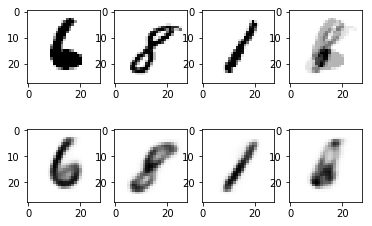

In [84]:
# interact cannot be shown in nbviewer so call the function directly
inBetween(0.2, 0.4)

#### 上圖說明
1. 
<table style="text-align:center;width:700px;border-collapse:collapse;">
   <tr>
        <td style="width:20%;">上排是原始資料:</td>
        <td style="width:12%;">圖片$A$</td>
        <td style="width:12%;">圖片$B$</td>
        <td style="width:12%;">圖片$C$</td>
        <td style="width:41%;">$(1 - t - s)A + t B + s C$</td>
    <tr>
        <td>下排是VAE的結果:</td>
        <td>$Dec(Enc(A))$</td>
        <td>$Dec(Enc(B))$</td>
        <td>$Dec(Enc(C))$</td>
        <td>$Dec( (1-t-s)Enc(A) + tEnc(B) + sEnc(C) )$</td>
</table>
2. 雖然稱為滑桿，但滑過去的話每個點都要算，會跑很久，建議用點的